Dowloading data from google cloud buckets and reading into dask bag.



In [ ]:
import dask.bag as db
import json
import gzip
import shutil
import multiprocessing
import os
import urllib.request

# downloading json.gz files from google cloud buckets
url = 'https://storage.googleapis.com/jsonstuff/goodreads_interactions_comics_graphic.json.gz'
filename = 'goodreads_interactions_comics_graphic.json.gz'
urllib.request.urlretrieve(url, filename)

# unzipping json.gz file
with gzip.open(filename, 'rb') as f_in:
  with open('goodreads_interactions_comics_graphic.json', 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

# reading file into dask bag
filename = 'goodreads_interactions_comics_graphic.json'
n_cpus = multiprocessing.cpu_count()
file_stats = os.stat(filename)
file_mb = file_stats.st_size / (1024 * 1024)
b = db.read_text(filename, blocksize=str((file_mb / n_cpus))+"MB")
parsed_bag = b.map(json.loads)

Cleans data by only keeping essential data, filtering for high ratings (4 or 5) and only if the user has read the book.

In [ ]:
def clean_data(bag):
  bag = bag.map(lambda x: (x['user_id'], x['book_id'], x['is_read'], x['rating']))
  bag = bag.filter(lambda x: x[3] >= 4 and x[2] is True)
  return bag

In [ ]:
cleaned_bag = clean_data(parsed_bag)

Transforms bag of filtered data into a transactional format where each record in the bag represents the user and all the shows they have reviewed.

In [ ]:
def transform_records(bag):
  n_cpus = multiprocessing.cpu_count()
  user_books = bag.foldby(key=lambda x: x[0], binop=lambda acc, x: acc + [x[1]], initial=[], combine=lambda acc1, acc2: acc1 + acc2 )
  user_books = user_books.repartition(n_cpus)
  user_books = user_books.pluck(1)
  return user_books

In [ ]:
users_reviewed_books = transform_records(cleaned_bag)

Gets individual item counts for the amount of times a book has been reviewed.

In [ ]:
def a_priori_step1(user_books_bag):
  item_counts = user_books_bag.flatten().frequencies()
  return item_counts

In [ ]:
frequent_items = a_priori_step1(users_reviewed_books)

Apriori algorithim. Only returns frequent itemsets with individual counts over the support level, default is 1000 when using whole dataset, however I use support = (lines in interaction data) * 0.0004, when testing a subset.

In [ ]:
def a_priori(text_file_bag, support=2000):
  item_counts = text_file_bag.flatten().frequencies()
  significant_item_counts = item_counts.filter(lambda x: x[1]>=support)
  significant_set = set(significant_item_counts.map(lambda x: x[0]).compute())

  def generate_frequent_pairs(books):
    pair_list = []
    for i in range(len(books)):
      if books[i] in significant_set:
        for j in range(i+1, len(books)):
          if books[j] in significant_set:
            pair_list.append(tuple(sorted((books[i], books[j]))))
    return pair_list
  pair_counts = text_file_bag.map(generate_frequent_pairs).flatten().frequencies()
  #pair_counts = pair_counts.repartition(n_cpus)
  return pair_counts

In [ ]:
ap_results = a_priori(users_reviewed_books)

Returns the confidence of each pair rule.




In [ ]:
def confidence(item_counts, pair_counts):
  split_pairs = pair_counts.map(lambda x: [(x[0][0], (x[0][1], x[1])), (x[0][1], (x[0][0], x[1]))]).flatten()
  joint = split_pairs.join(item_counts, lambda x: x[0])
  output = joint.map(lambda x: ((x[0][0],x[1][1][0]), x[1][1][1]/x[0][1]))

  return output

In [ ]:
rule_confidences = confidence(frequent_items, ap_results)
results = rule_confidences.topk(5, key=lambda x: x[1])

Loading in book meta data to retrieve titles of books.

In [ ]:
def load_book_metadata(jsongz):
  book_bag = db.read_text(jsongz).map(json.loads)
  titles = book_bag.map(lambda x: (x['book_id'], x['title']))
  return titles

In [ ]:
books_metadata_url = 'https://storage.googleapis.com/jsonstuff/goodreads_books_comics_graphic.json.gz'
titles = load_book_metadata(books_metadata_url)

In [ ]:
title_dict = dict(titles.compute())

In [ ]:
def get_titles_for_pair_fast(item):
    (book_id_1, book_id_2), count = item
    title1 = title_dict.get(book_id_1, "Unknown")
    title2 = title_dict.get(book_id_2, "Unknown")
    return ((title1, title2), count)


Printing the top 5 pairs of highly-rated books that most strongly predict the presence of another highly-rated book.

In [ ]:
top_titles = results.map(get_titles_for_pair_fast)

print(top_titles.compute())

[(('Death Note, Vol. 2: Confluence (Death Note, #2)', 'Death Note, Vol. 1: Boredom (Death Note, #1)'), 0.934113712374582), (('Death Note, Vol. 4: Love (Death Note, #4)', 'Death Note, Vol. 3: Hard Run (Death Note, #3)'), 0.9303043670048522), (('Death Note, Vol. 4: Love (Death Note, #4)', 'Death Note, Vol. 1: Boredom (Death Note, #1)'), 0.9303043670048522), (('Death Note, Vol. 5: Whiteout (Death Note, #5)', 'Death Note, Vol. 1: Boredom (Death Note, #1)'), 0.9297029702970298), (('Death Note, Vol. 3: Hard Run (Death Note, #3)', 'Death Note, Vol. 2: Confluence (Death Note, #2)'), 0.928766056831452)]


# Running the program on the cloud

In [ ]:
%%writefile dask_apriori.py
# the above line tells colab to write the contents of this cell to a file instead of running them
import time
import sys
import multiprocessing
import os
import urllib.request
import dask.bag as db
import json
import gzip
from itertools import islice



def clean_data(bag):
  bag = bag.map(lambda x: (x['user_id'], x['book_id'], x['is_read'], x['rating']))
  bag = bag.filter(lambda x: x[3] >= 4 and x[2] is True)
  return bag

def transform_records(bag)
  user_books = bag.foldby(key=lambda x: x[0], binop=lambda acc, x: acc + [x[1]], initial=[], combine=lambda acc1, acc2: acc1 + acc2 )
  user_books = user_books.repartition(n_cpus)
  user_books = user_books.pluck(1)
  return user_books

def a_priori_step1(text_file_bag):
  item_counts = text_file_bag.flatten().frequencies()
  return item_counts

def a_priori(text_file_bag, support=1000):
  item_counts = text_file_bag.flatten().frequencies()
  significant_item_counts = item_counts.filter(lambda x: x[1]>=support)
  significant_set = set(significant_item_counts.map(lambda x: x[0]).compute())

  def generate_frequent_pairs(books):
    pair_list = []
    for i in range(len(books)):
      if books[i] in significant_set:
        for j in range(i+1, len(books)):
          if books[j] in significant_set:
            pair_list.append(tuple(sorted((books[i], books[j]))))
    return pair_list
  pair_counts = text_file_bag.map(generate_frequent_pairs).flatten().frequencies()
  pair_counts = pair_counts.repartition(n_cpus)
  return pair_counts

def confidence(item_counts, pair_counts):
  split_pairs = pair_counts.map(lambda x: [(x[0][0], (x[0][1], x[1])), (x[0][1], (x[0][0], x[1]))]).flatten()
  print(f' conggg {split_pairs.npartitions}')
  joint = split_pairs.join(item_counts, lambda x: x[0])
  output = joint.map(lambda x: ((x[0][0],x[1][1][0]), x[1][1][1]/x[0][1]))

  return output

def load_book_metadata(jsongz):
  book_bag = db.read_text(jsongz).map(json.loads)
  titles = book_bag.map(lambda x: (x['book_id'], x['title']))
  return titles

def get_titles_for_pair_fast(item):
    (book_id_1, book_id_2), count = item
    title1 = title_dict.get(book_id_1, "Unknown")
    title2 = title_dict.get(book_id_2, "Unknown")
    return ((title1, title2), count)


if __name__ == "__main__":
  url = 'https://storage.googleapis.com/jsonstuff/goodreads_interactions_comics_graphic.json.gz'
  filename = 'goodreads_interactions_comics_graphic.json.gz'
  second_url = 'https://storage.googleapis.com/jsonstuff/goodreads_books_comics_graphic.json.gz'
  second_file = 'goodreads_books_comics_graphic.json.gz'
  urllib.request.urlretrieve(url, filename)

  if len(sys.argv) >= 2:
    filesize = int(sys.argv[1])

  with gzip.open(filename, 'rt') as f_in:
    with open('subset_interactions.json', 'w') as f_out:
        for line in islice(f_in, filesize):
            f_out.write(line)

  n_cpus = multiprocessing.cpu_count()

  if len(sys.argv) == 3:
    n_cpus = int(sys.argv[2])

  from dask import bag as db
  from dask.distributed import LocalCluster
  from dask.distributed import Client
  from dask.distributed import get_task_stream

  cluster = LocalCluster(n_workers=n_cpus, threads_per_worker=1) # force to start 8 processes if we have 8 cpus
  print(cluster)
  client = cluster.get_client()

  with get_task_stream(plot='save', filename=f"task-stream-{n_cpus}.html") as ts:
    # force load of text file into partitions so that each process has one chunk
    filename = 'subset_interactions.json'  # uncompressed file
    file_stats = os.stat(filename)
    file_mb = file_stats.st_size / (1024 * 1024)
    b = db.read_text(filename, blocksize=str((file_mb / n_cpus))+"MB")

    parsed_bag = b.map(json.loads)

    titles = load_book_metadata(second_url)

    dict_start = time.time()
    title_dict = dict(titles.compute())
    dict_end = time.time()
    print(f'dictionary_create time: {dict_end - dict_start:.4f} s')

    time_start = time.time()

    clean_start = time.time()
    cleaned_bag = clean_data(parsed_bag)
    clean_end = time.time()
    print(f'clean data time: {clean_end - clean_start:.4f} s')

    users_reviewed_books = transform_records(cleaned_bag)

    freq_start = time.time()
    frequent_items = a_priori_step1(users_reviewed_books)
    freq_end = time.time()
    print(f'item freq time: {freq_end - freq_start:.4f} s')

    apriori_start = time.time()
    ap_results= a_priori(users_reviewed_books, filesize*0.0004)
    apriori_end = time.time()
    print(f'apriori algorithim time: {apriori_end - apriori_start:.4f} s')

    conf_start = time.time()
    rule_confidences = confidence(frequent_items, ap_results)
    conf_end = time.time()
    print(f'confidence calculation time: {conf_end - conf_start:.4f} s')

    top_start = time.time()
    results = rule_confidences.topk(5, key=lambda x: x[1])
    top_end = time.time()
    print(f'get top5 time: {top_end - top_start:.4f} s')

    map_start = time.time()
    top_titles = results.map(get_titles_for_pair_fast)
    map_end = time.time()
    print(f'get titles timez: {map_end - map_start:.4f} s')

    compute_start = time.time()
    print(top_titles.compute())
    print(f'compute time: {time.time() - compute_start:.4f} s')

    time_total = time.time() - time_start
    print(f'total elapsed time: {time_total:.4f} s')

Overwriting dask_apriori.py


In [ ]:
USERNAME="jke"
%env REGION=australia-southeast1
%env ZONE=
%env PROJECT=data301-project-2025-jke139
%env CLUSTER=data301-project-2025-jke139-cluster
%env INSTANCE=data301-project-2025-jke139-cluster-m

env: REGION=australia-southeast1
env: ZONE=
env: PROJECT=data301-project-2025-jke139
env: CLUSTER=data301-project-2025-jke139-cluster
env: INSTANCE=data301-project-2025-jke139-cluster-m


In [ ]:
!gcloud auth login

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=aOoWK5bku4rguTzYMN5iJLjQeUvaOd&prompt=consent&token_usage=remote&access_type=offline&code_challenge=6i4ehEOoj9m6lqZC_2A93nEWkvh3N2ag3knqa5V0h2s&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AUJR-x4zZtxrZQWyQQZ40x0oZPj4Hl_nOOe4SjaLO2rmVIpOR7YVr5Q0LwGRmCWXnH8Fbg

You are now logged in as [joelkennerley@gmail.com].
Your current projec

In [ ]:
# Set the project environment variable and enable dataproc on it
!gcloud config set project data301-project-2025-jke139
!gcloud services enable dataproc.googleapis.com cloudresourcemanager.googleapis.com

Updated property [core/project].
Operation "operations/acat.p2-671027123683-17f9d519-cd45-4655-9095-af9a6b1709f3" finished successfully.


In [ ]:
# This command actually starts the cluster. It may take up to 5-10 minutes before
#  showing the completion dialog which should be
!gcloud dataproc clusters create $CLUSTER --region=$REGION --zone=$ZONE \
  --master-machine-type n2-standard-8 \
  --master-boot-disk-size 100 \
  --image-version 2.2-ubuntu22 \
  --max-age=30m \
  --public-ip-address \
  --num-masters=1 --num-workers=0

# NOTE: the above arguments should be self-explanatory; you can read more here: https://cloud.google.com/sdk/gcloud/reference/dataproc/clusters/create
# The 30minute age will ensure the cluster shuts down if you forget or get disconnected from colab
# We only use 1 master node and 0 worker nodes as our 1 master node is an
# n2-standard-8 which has 8 virtual CPUs

Waiting on operation [projects/data301-project-2025-jke139/regions/australia-southeast1/operations/ca478f31-ea7f-345f-836c-abbee00cc2ed].

Created [https://dataproc.googleapis.com/v1/projects/data301-project-2025-jke139/regions/australia-southeast1/clusters/data301-project-2025-jke139-cluster] Cluster placed in zone [australia-southeast1-b].


In [ ]:
# first argument is file size, second is number of cpu's
!gcloud dataproc jobs submit pyspark --cluster=$CLUSTER --region=$REGION dask_apriori.py -- 200000 1

ERROR: (gcloud.dataproc.jobs.submit.pyspark) NOT_FOUND: Not found: Cluster projects/data301-project-2025-jke139/regions/australia-southeast1/clusters/data301-project-2025-jke139-cluster. This command is authenticated as joelkennerley@gmail.com which is the active account specified by the [core/account] property


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster=$CLUSTER --region=$REGION dask_apriori.py -- 400000 1

Job [af375f54e8034cb18386bc1db4370730] submitted.
Waiting for job output...
LocalCluster(ca1bb792, 'tcp://127.0.0.1:34031', workers=1, threads=1, memory=31.34 GiB)
20000
dictionary_create 33.8804 s
clean 0.0009 s
freq 0.0002 s
apriori 0.1588 s
 conggg 1
conf 0.0008 s
top5 0.0003 s
get titles 0.0908 s
[(('The Wake (The Sandman #10)', 'The Kindly Ones (The Sandman #9)'), 1.0), (('The Kindly Ones (The Sandman #9)', 'The Wake (The Sandman #10)'), 1.0), (('The Wake (The Sandman #10)', 'Fables and Reflections (The Sandman #6)'), 1.0), (('The Wake (The Sandman #10)', 'Season of Mists (The Sandman #4)'), 1.0), (("Worlds' End (The Sandman #8)", 'Season of Mists (The Sandman #4)'), 1.0)]
compute 0.3479 s
total elapsed time: 0.5998 s
Job [af375f54e8034cb18386bc1db4370730] finished successfully.
done: true
driverControlFilesUri: gs://dataproc-staging-au-southeast1-671027123683-vhfxhien/google-cloud-dataproc-metainfo/ce44fd9c-c258-4067-867a-7679612bbe5b/jobs/af375f54e8034cb18386bc1db4370730/
driver

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster=$CLUSTER --region=$REGION dask_apriori.py -- 800000 1

Job [9bb9fa12e57c464f96c8027ceee08c21] submitted.
Waiting for job output...
LocalCluster(be6f5694, 'tcp://127.0.0.1:37427', workers=1, threads=1, memory=31.34 GiB)
40000
dictionary_create 34.0683 s
clean 0.0010 s
freq 0.0002 s
apriori 0.2925 s
 conggg 1
conf 0.0008 s
top5 0.0003 s
get titles 0.0884 s
[(('The Walking Dead, Vol. 05: The Best Defense', "The Walking Dead, Vol. 04: The Heart's Desire"), 1.0), (('Saga, Vol. 3 (Saga, #3)', 'Saga, Vol. 2 (Saga, #2)'), 0.9803921568627451), (('Fables and Reflections (The Sandman #6)', 'Preludes & Nocturnes (The Sandman #1)'), 0.9444444444444444), (('Ms. Marvel, Vol. 2: Generation Why', 'Ms. Marvel, Vol. 1: No Normal'), 0.9444444444444444), (('Saga, Vol. 7 (Saga, #7)', 'Saga, Vol. 2 (Saga, #2)'), 0.9444444444444444)]
compute 0.4644 s
total elapsed time: 0.8481 s
Job [9bb9fa12e57c464f96c8027ceee08c21] finished successfully.
done: true
driverControlFilesUri: gs://dataproc-staging-au-southeast1-671027123683-vhfxhien/google-cloud-dataproc-metainfo/ce

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster=$CLUSTER --region=$REGION dask_apriori.py -- 1600000 1

Job [9c24890c0c4644359c4f7772055bb721] submitted.
Waiting for job output...
LocalCluster(fe3160d8, 'tcp://127.0.0.1:33111', workers=1, threads=1, memory=31.34 GiB)
80000
dictionary_create 33.8192 s
clean 0.0010 s
freq 0.0002 s
apriori 0.5775 s
 conggg 1
conf 0.0014 s
top5 0.0003 s
get titles 0.0895 s
[(('Saga, Vol. 3 (Saga, #3)', 'Saga, Vol. 2 (Saga, #2)'), 0.9772727272727273), (('The Walking Dead, Vol. 03: Safety Behind Bars', 'The Walking Dead, Vol. 01: Days Gone Bye'), 0.9705882352941176), (('Saga, Vol. 7 (Saga, #7)', 'Saga, Vol. 2 (Saga, #2)'), 0.9696969696969697), (('A Game of You (The Sandman #5)', 'Season of Mists (The Sandman #4)'), 0.9459459459459459), (('The Walking Dead, Vol. 03: Safety Behind Bars', 'The Walking Dead, Vol. 02: Miles Behind Us'), 0.9411764705882353)]
compute 0.7859 s
total elapsed time: 1.4564 s
Job [9c24890c0c4644359c4f7772055bb721] finished successfully.
done: true
driverControlFilesUri: gs://dataproc-staging-au-southeast1-671027123683-vhfxhien/google-clou

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster=$CLUSTER --region=$REGION dask_apriori.py -- 400000 2

Job [6f62ed07f388446588c43a25869ee88b] submitted.
Waiting for job output...
LocalCluster(a042ff46, 'tcp://127.0.0.1:46291', workers=2, threads=2, memory=31.34 GiB)
20000
dictionary_create 34.5771 s
clean 0.0010 s
freq 0.0002 s
apriori 0.1428 s
 conggg 2
conf 0.0009 s
top5 0.0003 s
get titles 0.0940 s
[(('The Wake (The Sandman #10)', 'The Kindly Ones (The Sandman #9)'), 1.0), (('The Kindly Ones (The Sandman #9)', 'The Wake (The Sandman #10)'), 1.0), (('The Wake (The Sandman #10)', 'Fables and Reflections (The Sandman #6)'), 1.0), (('The Wake (The Sandman #10)', 'Season of Mists (The Sandman #4)'), 1.0), (("Worlds' End (The Sandman #8)", 'Season of Mists (The Sandman #4)'), 1.0)]
compute 0.4009 s
total elapsed time: 0.6406 s
Job [6f62ed07f388446588c43a25869ee88b] finished successfully.
done: true
driverControlFilesUri: gs://dataproc-staging-au-southeast1-671027123683-vhfxhien/google-cloud-dataproc-metainfo/ce44fd9c-c258-4067-867a-7679612bbe5b/jobs/6f62ed07f388446588c43a25869ee88b/
driver

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster=$CLUSTER --region=$REGION dask_apriori.py -- 800000 4

Job [6964590dffbd4bc4af5ed73afd8af2c3] submitted.
Waiting for job output...
LocalCluster(bf039a9f, 'tcp://127.0.0.1:45915', workers=4, threads=4, memory=31.34 GiB)
40000
dictionary_create 34.0993 s
clean 0.0010 s
freq 0.0002 s
apriori 0.1848 s
 conggg 4
conf 0.0009 s
top5 0.0002 s
get titles 0.0903 s
[(('The Walking Dead, Vol. 05: The Best Defense', "The Walking Dead, Vol. 04: The Heart's Desire"), 1.0), (('Saga, Vol. 3 (Saga, #3)', 'Saga, Vol. 2 (Saga, #2)'), 0.9803921568627451), (('Fables and Reflections (The Sandman #6)', 'Preludes & Nocturnes (The Sandman #1)'), 0.9444444444444444), (('Ms. Marvel, Vol. 2: Generation Why', 'Ms. Marvel, Vol. 1: No Normal'), 0.9444444444444444), (('Saga, Vol. 7 (Saga, #7)', 'Saga, Vol. 2 (Saga, #2)'), 0.9444444444444444)]
compute 0.8051 s
total elapsed time: 1.0828 s
Job [6964590dffbd4bc4af5ed73afd8af2c3] finished successfully.
done: true
driverControlFilesUri: gs://dataproc-staging-au-southeast1-671027123683-vhfxhien/google-cloud-dataproc-metainfo/ce

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster=$CLUSTER --region=$REGION dask_apriori.py -- 1600000 8

Job [0b4c6ea1068e4e6dbd58eae955c80308] submitted.
Waiting for job output...
LocalCluster(e9c66a14, 'tcp://127.0.0.1:45435', workers=8, threads=8, memory=31.34 GiB)
80000
dictionary_create 33.3059 s
clean 0.0011 s
freq 0.0002 s
apriori 0.2477 s
 conggg 8
conf 0.0012 s
top5 0.0003 s
get titles 0.0903 s
[(('Saga, Vol. 3 (Saga, #3)', 'Saga, Vol. 2 (Saga, #2)'), 0.9772727272727273), (('The Walking Dead, Vol. 03: Safety Behind Bars', 'The Walking Dead, Vol. 01: Days Gone Bye'), 0.9705882352941176), (('Saga, Vol. 7 (Saga, #7)', 'Saga, Vol. 2 (Saga, #2)'), 0.9696969696969697), (('A Game of You (The Sandman #5)', 'Season of Mists (The Sandman #4)'), 0.9459459459459459), (('The Walking Dead, Vol. 03: Safety Behind Bars', 'The Walking Dead, Vol. 02: Miles Behind Us'), 0.9411764705882353)]
compute 2.4708 s
total elapsed time: 2.8117 s
Job [0b4c6ea1068e4e6dbd58eae955c80308] finished successfully.
done: true
driverControlFilesUri: gs://dataproc-staging-au-southeast1-671027123683-vhfxhien/google-clou

Plot measuring scalability on a single processor

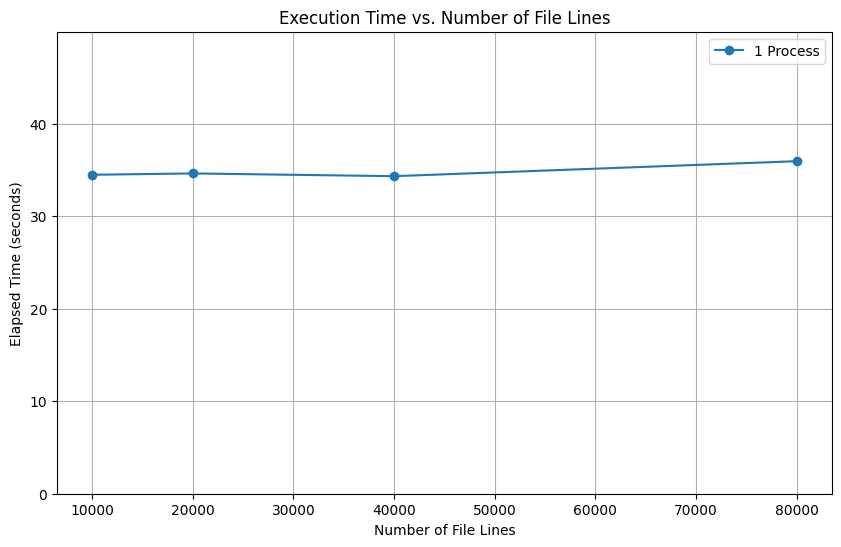

In [ ]:
import matplotlib.pyplot as plt

file_sizes = [10000, 20000, 40000, 80000]
elapsed_times_1_process = [34.48950982093811, 34.634485721588135, 34.33740568161011, 35.95807671546936]

plt.figure(figsize=(10, 6))
plt.plot(file_sizes, elapsed_times_1_process, marker='o', linestyle='-', label='1 Process')

plt.xlabel("Number of File Lines")
plt.ylabel("Elapsed Time (seconds)")
plt.title("Execution Time vs. Number of File Lines")
plt.grid(True)
plt.ylim(0, max(elapsed_times_1_process) + 14)
plt.legend()
plt.show()

Plot measuring weak scalability using processors 1, 2, 4, and 8 with file sizes 10,000, 20,000, 40,000 and 80,000 lines.

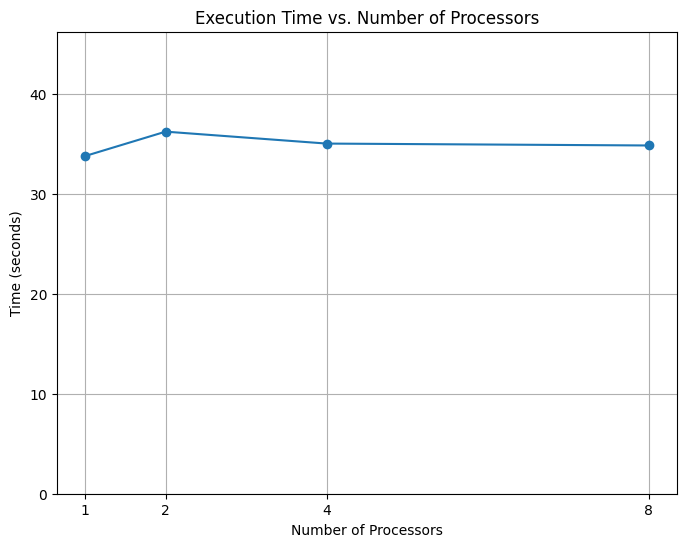

In [ ]:
import matplotlib.pyplot as plt

processors = [1, 2, 4, 8]
times = [33.794820070266724, 36.23728942871094, 35.043009519577026, 34.85246181488037]

plt.figure(figsize=(8, 6))
plt.plot(processors, times, marker='o')
plt.xlabel('Number of Processors')
plt.ylabel('Time (seconds)')
plt.title('Execution Time vs. Number of Processors')
plt.grid(True)
plt.xticks(processors)
plt.ylim(0, max(times) + 10)
plt.show()


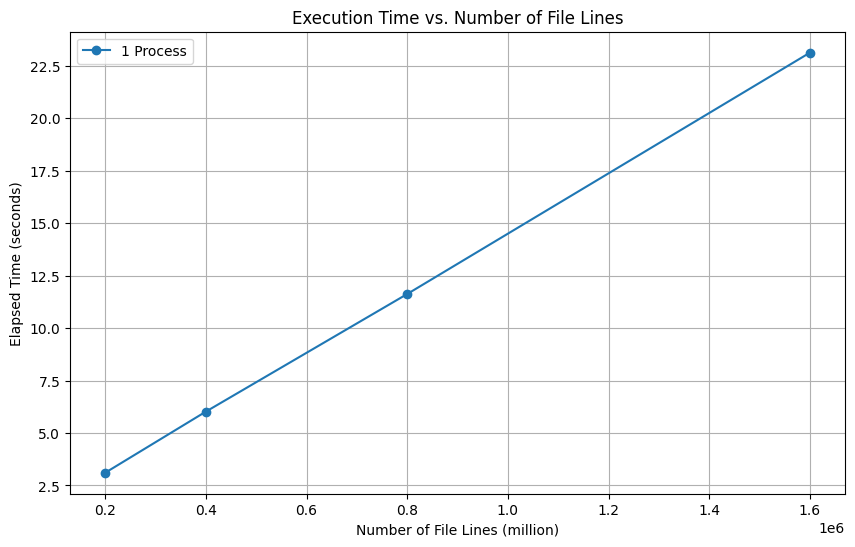

In [ ]:
file_lines = [200000, 400000, 800000, 1600000]
time_1_process = [3.1081, 6.0202, 11.6211, 23.1151]

plt.figure(figsize=(10, 6))

plt.plot(file_lines, time_1_process, marker='o', linestyle='-', label='1 Process')

plt.xlabel("Number of File Lines (million)")
plt.ylabel("Elapsed Time (seconds)")
plt.title("Execution Time vs. Number of File Lines")
plt.grid(True)
plt.legend()
plt.show()


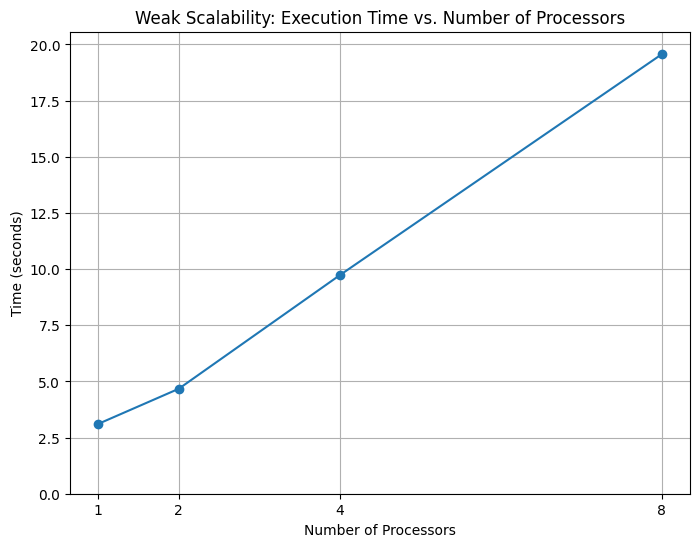

In [ ]:
processors = [1, 2, 4, 8]
times = [3.1081, 4.6712, 9.7280, 19.5664]

plt.figure(figsize=(8, 6))
plt.plot(processors, times, marker='o')
plt.xlabel('Number of Processors')
plt.ylabel('Time (seconds)')
plt.title('Weak Scalability: Execution Time vs. Number of Processors')
plt.grid(True)
plt.xticks(processors)
plt.ylim(0, max(times) + 1)
plt.show()
